# 02 - velocity estimation

In [1]:
%matplotlib inline
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd

from scipy import sparse
from matplotlib import rcParams

random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3

scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.settings.set_figure_params("scvelo")

In [2]:
def run_scvelo(adata):
    """Run basic workflow for computing velocities."""
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2_000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.recover_dynamics(adata, n_jobs=25)
    scv.tl.velocity(adata, mode="dynamical")
    scv.tl.velocity_graph(adata)

    return adata


def buildAnndataFromStar(path):
    """Generate an anndata object from the STAR aligner output folder"""
    path = path
    # Load Read Counts
    X = sc.read_mtx(path + "Gene/raw/matrix.mtx")

    # Transpose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    X = X.X.transpose()

    # This matrix is organized as a sparse matrix with Row, Cols and 3 values columns for
    # Spliced, Unspliced and Ambigous reads
    mtx = np.loadtxt(path + "Velocyto/raw/matrix.mtx", skiprows=3, delimiter=" ")
    # Extract sparse matrix shape informations from the third row
    shape = np.loadtxt(
        path + "Velocyto/raw/matrix.mtx", skiprows=2, max_rows=1, delimiter=" "
    )[0:2].astype(int)

    # Read the sparse matrix with csr_matrix((data, (row_ind, col_ind)), shape=(M, N))
    # Subract -1 to rows and cols index because csr_matrix expects a 0 based index
    # Traspose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    spliced = sparse.csr_matrix(
        (mtx[:, 2], (mtx[:, 0] - 1, mtx[:, 1] - 1)), shape=shape
    ).transpose()
    unspliced = sparse.csr_matrix(
        (mtx[:, 3], (mtx[:, 0] - 1, mtx[:, 1] - 1)), shape=shape
    ).transpose()
    ambiguous = sparse.csr_matrix(
        (mtx[:, 4], (mtx[:, 0] - 1, mtx[:, 1] - 1)), shape=shape
    ).transpose()

    # Load Genes and Cells identifiers
    obs = pd.read_csv(path + "Velocyto/raw/barcodes.tsv", header=None, index_col=0)
    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None

    var = pd.read_csv(
        path + "Velocyto/raw/features.tsv",
        sep="\t",
        names=("gene_ids", "feature_types"),
        index_col=1,
    )

    # Build AnnData object to be used with ScanPy and ScVelo
    adata = sc.AnnData(
        X=X,
        obs=obs,
        var=var,
        layers={"spliced": spliced, "unspliced": unspliced, "ambiguous": ambiguous},
    )
    adata.var_names_make_unique()

    # Subset Cells based on STAR filtering
    selected_barcodes = pd.read_csv(path + "Gene/filtered/barcodes.tsv", header=None)
    adata = adata[selected_barcodes[0]]

    return adata.copy()

In [3]:
adata = sc.read("../data/processed/01_dataset.h5ad")

## Merge spliced/unspliced matrices

In [ ]:
adata.obs['barcodes'] = adata.obs['Pool_barcode'].str.strip() + adata.obs['Cell_barcode'].str.strip()

sb1 = buildAnndataFromStar("../data/raw/velocity/SB1/Solo.out/")
sb2 = buildAnndataFromStar("../data/raw/velocity/SB2/Solo.out/")

# Merge velocity
sb1_obs = adata.obs[adata.obs.Batch == 'SB1'].reset_index().set_index('barcodes')
sb2_obs = adata.obs[adata.obs.Batch == 'SB2'].reset_index().set_index('barcodes')

common_cells_sb1 = np.intersect1d(sb1_obs.index, sb1.obs_names)
common_cells_sb2 = np.intersect1d(sb2_obs.index, sb2.obs_names)

sb1 = sb1[common_cells_sb1]
sb2 = sb2[common_cells_sb2]

sb1.obs = sb1_obs.loc[common_cells_sb1]
sb2.obs = sb2_obs.loc[common_cells_sb2]

# merge
merged = sb1.concatenate(sb2, index_unique='')
merged.obs = merged.obs.set_index('Well_ID')

# save
merged.write('../data/processed/02_velocity.h5ad')

## Remove 2iLIF cells for velocity inference

In [4]:
adata = adata[adata.obs.Stage != '2iLIF_PrE'].copy()

sc.pp.neighbors(adata, random_state=random_seed)
sc.tl.umap(adata, random_state=random_seed)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


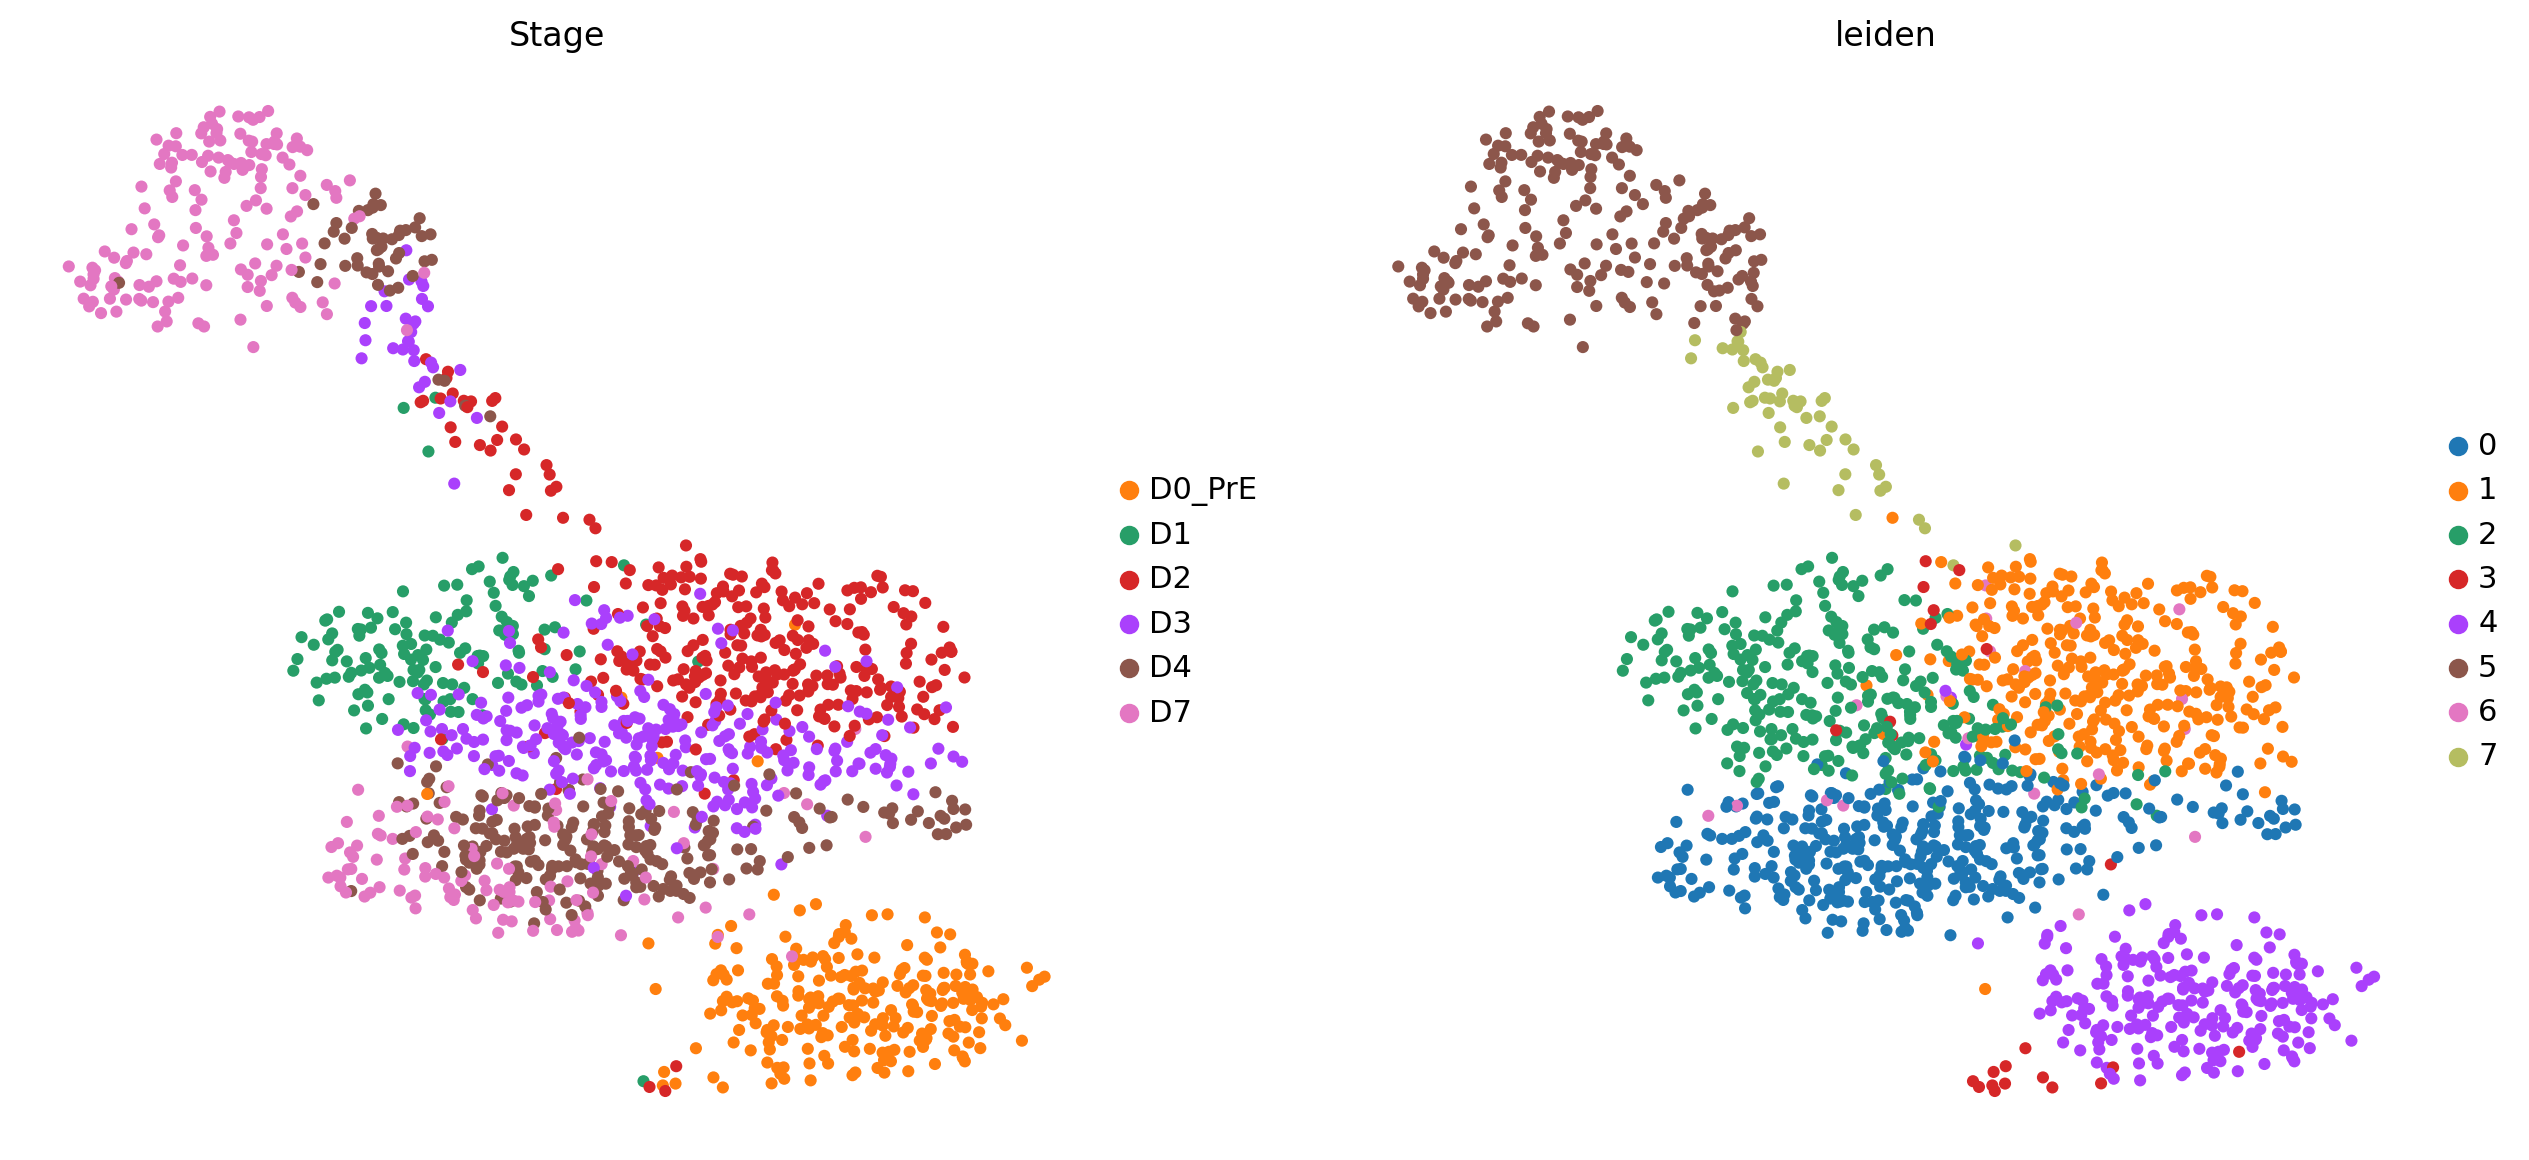

In [5]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata, color=['Stage', 'leiden'], ncols=2, frameon=False)

## Velocity

In [6]:
velocity = sc.read("../data/processed/02_velocity.h5ad")

In [7]:
adata_velocity = scv.utils.merge(adata, velocity)
adata_velocity.X = adata.layers['raw']
adata_velocity.raw = adata_velocity

adata_velocity

AnnData object with n_obs × n_vars = 1575 × 20459
    obs: 'Well_coordinates', 'plate_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'Day', 'Index sort', 'All.Events.FSC-A.Geo.Mean', 'All.Events.SSC-A.Geo.Mean', 'All.Events.GFP-A.Geo.Mean', 'All.Events.mCherry.561D-A.Geo.Mean', 'All.Events.DAPI-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'leiden', 'umap_density_Stage', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'mt', 'ercc', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'gene_ids'
    uns: 'Batch_colors', 'Stage_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 

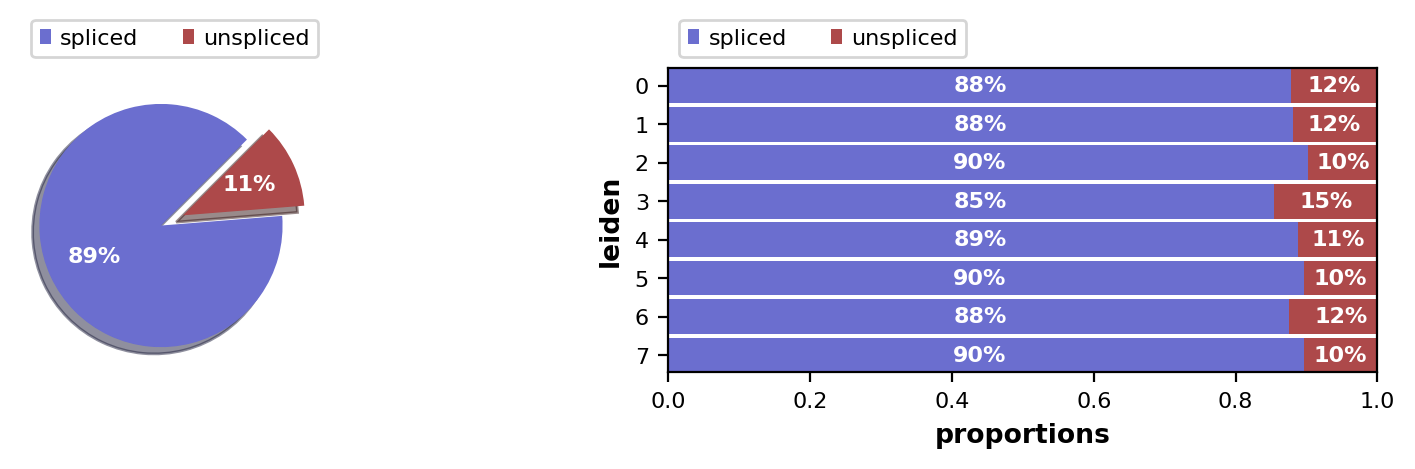

In [8]:
scv.pl.proportions(adata_velocity, groupby="leiden")

In [9]:
run_scvelo(adata_velocity)
scv.tl.terminal_states(adata_velocity, random_state=random_seed)

Filtered out 16535 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 25/224 cores)


  0%|          | 0/534 [00:00<?, ?gene/s]

    finished (0:02:55) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/224 cores)


  0%|          | 0/1575 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


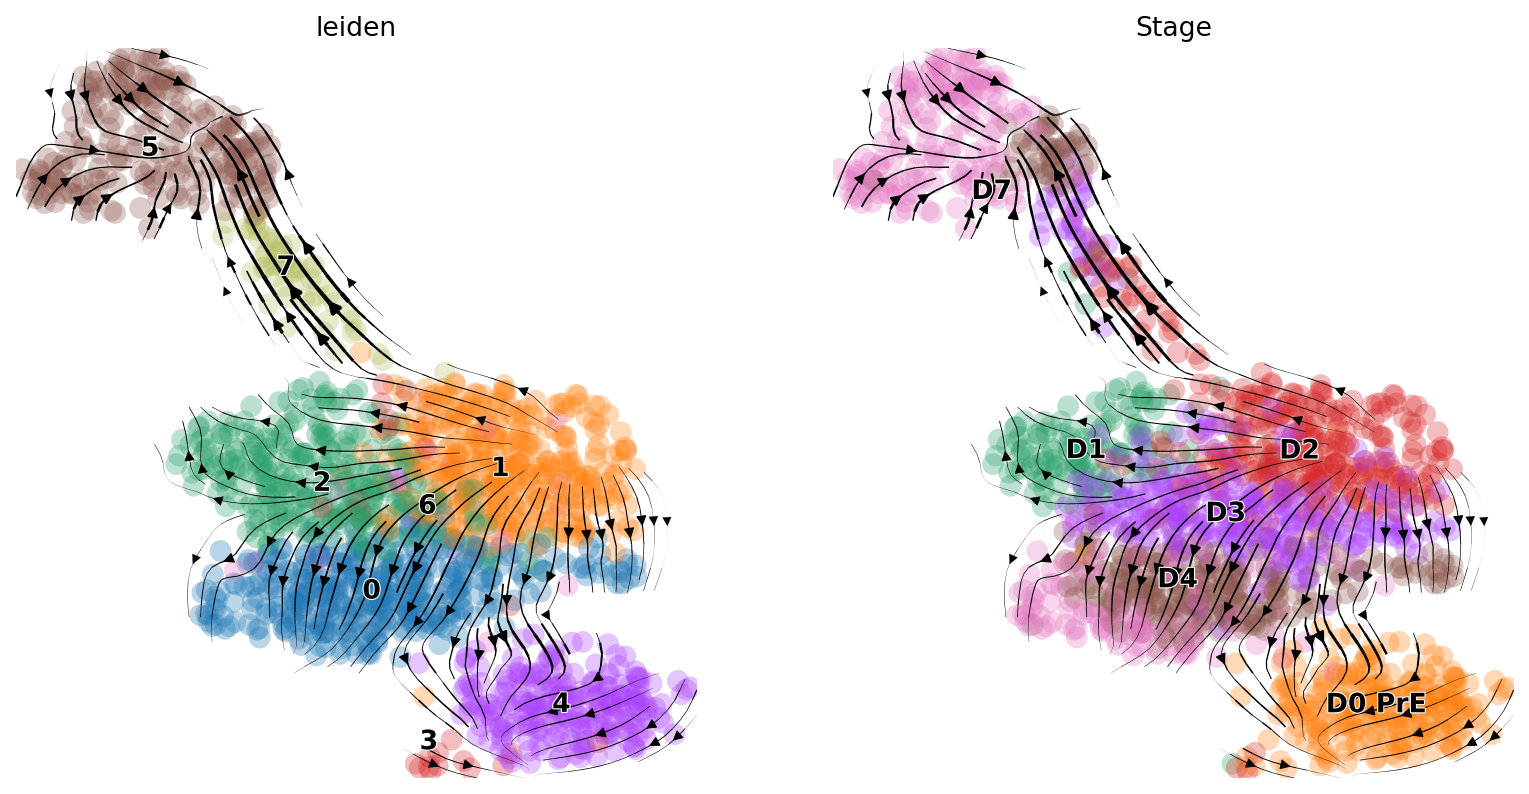

In [10]:
scv.pl.velocity_embedding_stream(adata_velocity, basis='umap', color=['leiden', 'Stage'])

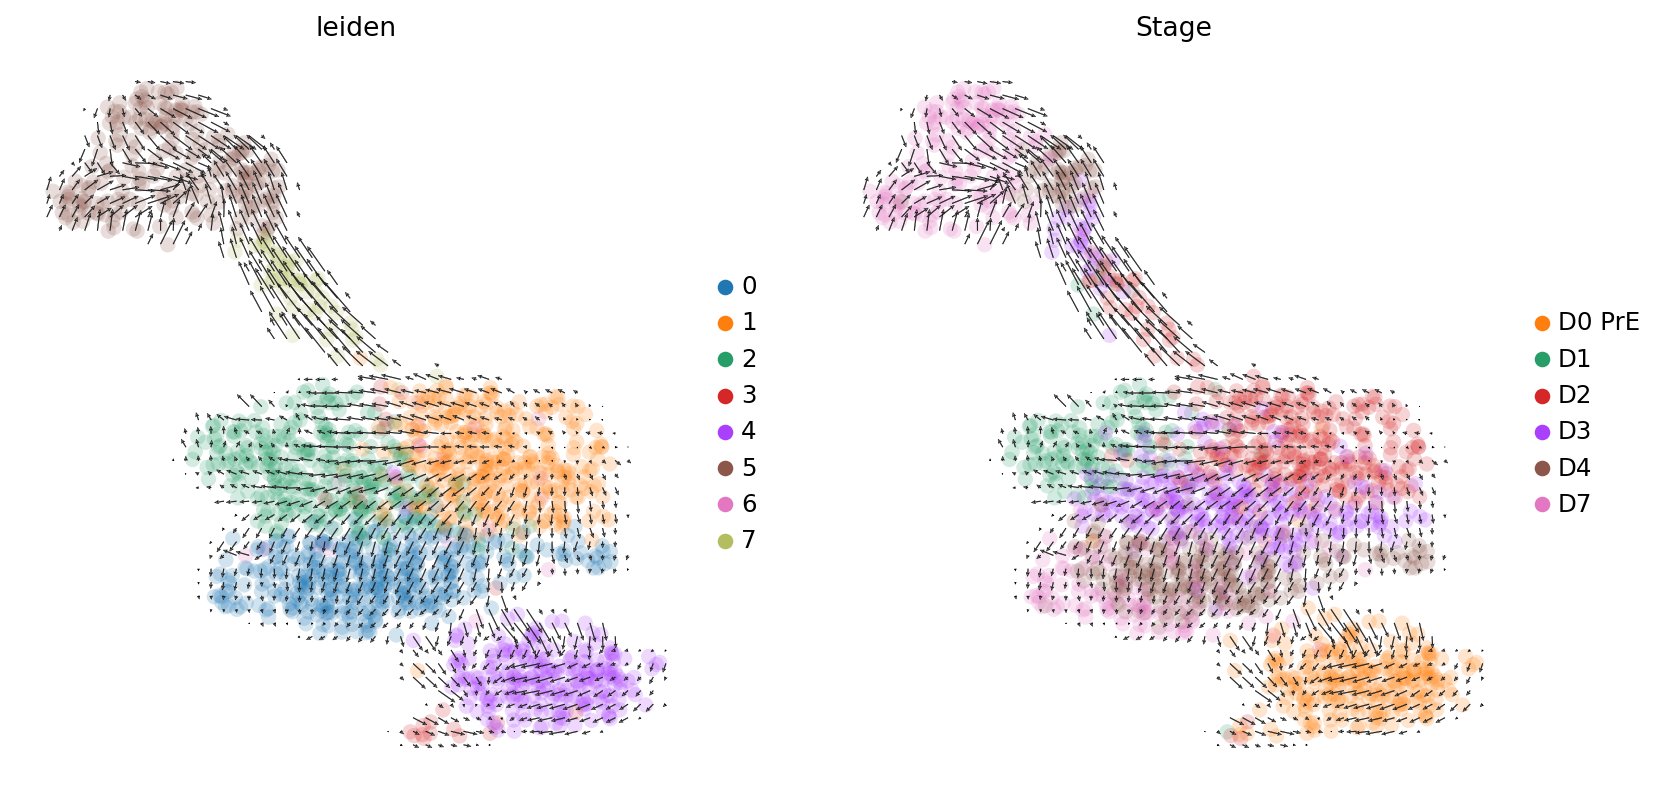

In [11]:
scv.pl.velocity_embedding_grid(adata_velocity, 
                               color=['leiden', 'Stage'], arrow_length=3, legend_loc = 'right')

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root cell 0 as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


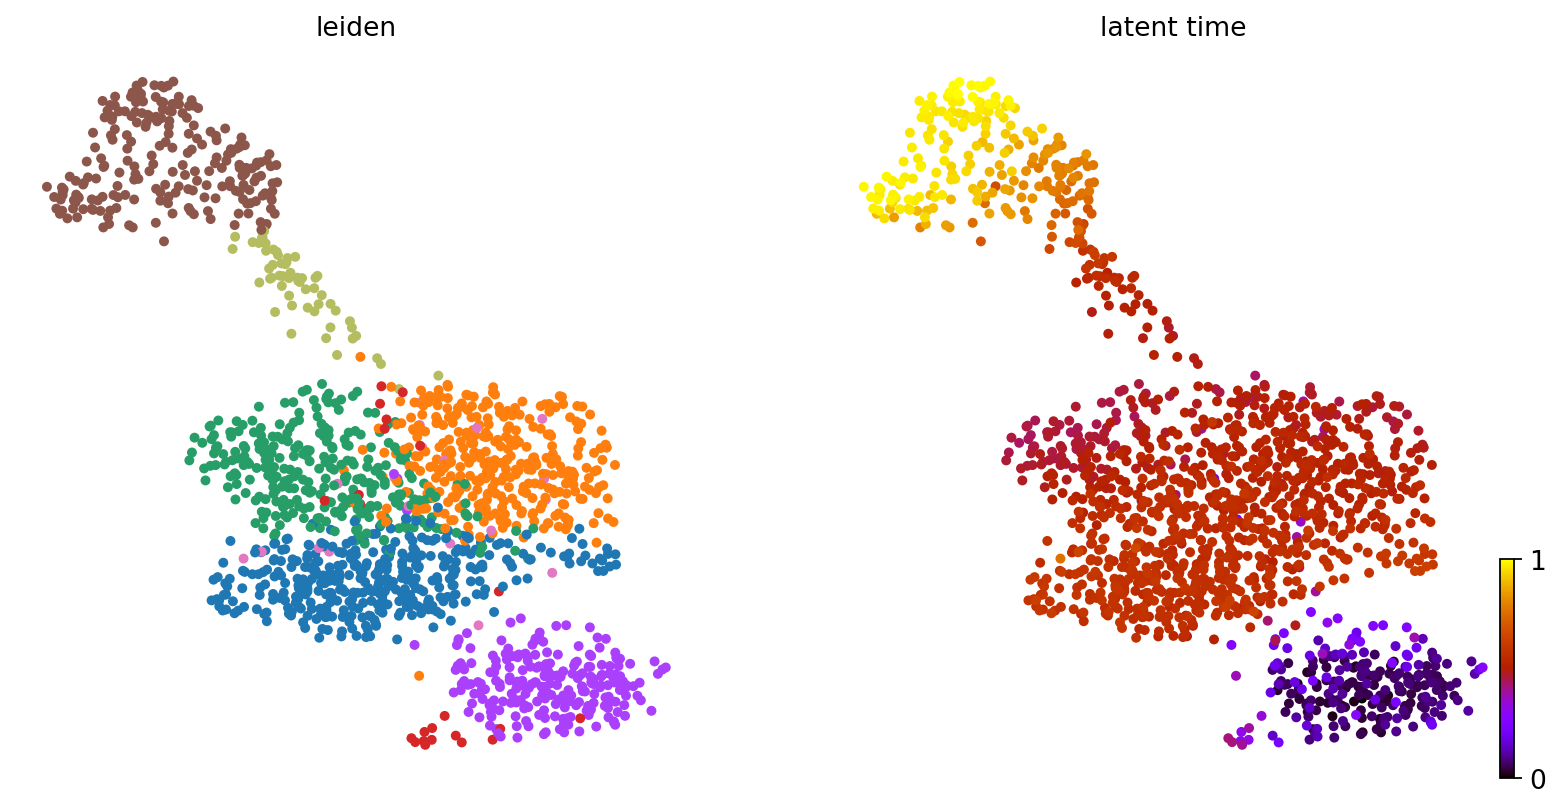

In [13]:
adata_velocity.uns['iroot'] = np.flatnonzero(adata_velocity.obs['Stage'] == 'D0_PrE')[0]
scv.tl.latent_time(adata_velocity, root_key='iroot')
scv.pl.scatter(adata_velocity, color=['leiden', 'latent_time'], color_map='gnuplot', size=80, colorbar=True)

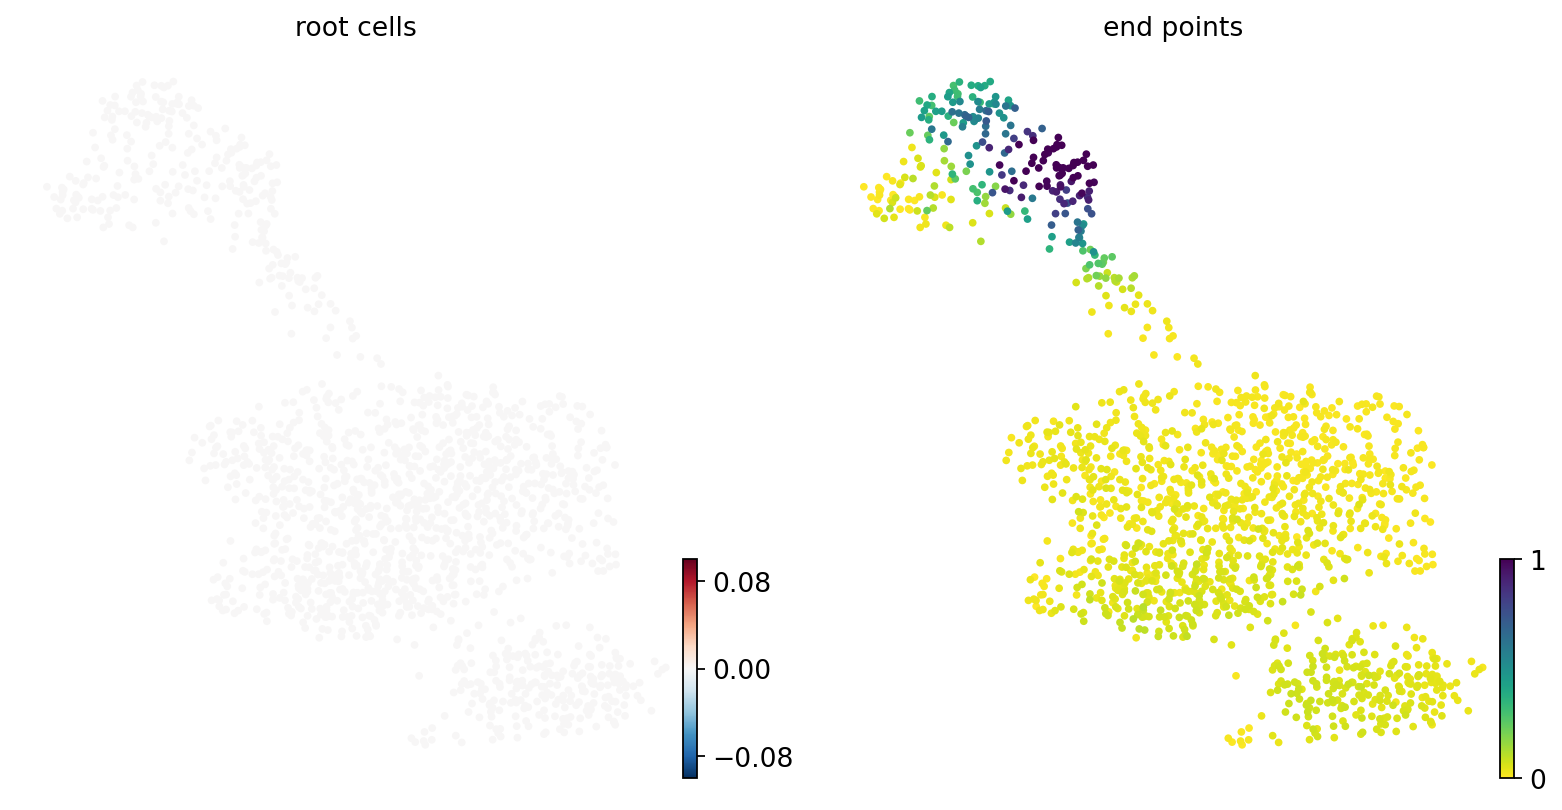

In [14]:
scv.pl.scatter(adata_velocity, color=['root_cells', 'end_points'])

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


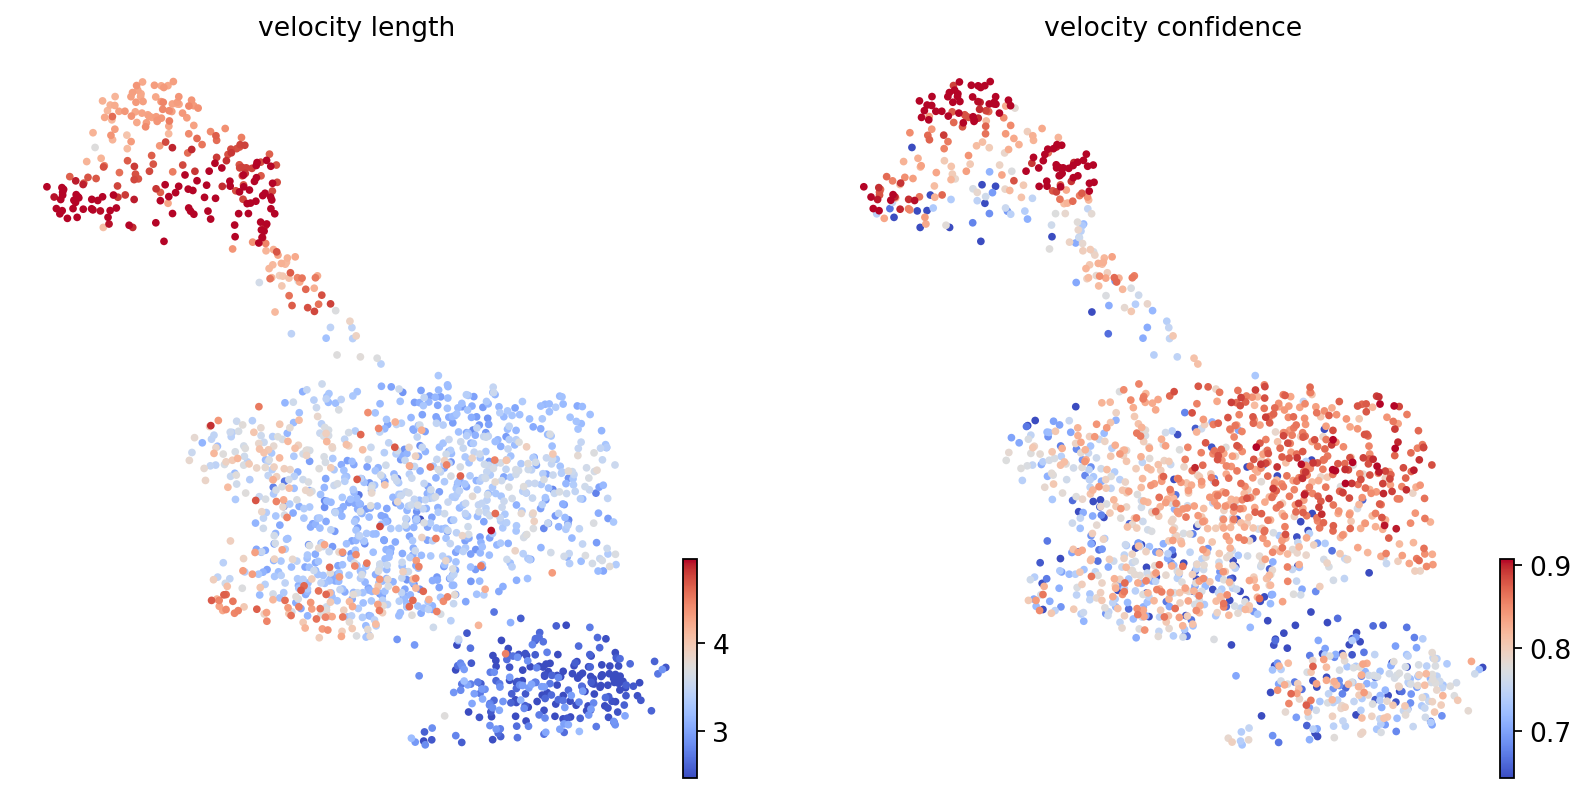

In [15]:
scv.tl.velocity_confidence(adata_velocity)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata_velocity, c=keys, cmap='coolwarm', perc=[5, 95])

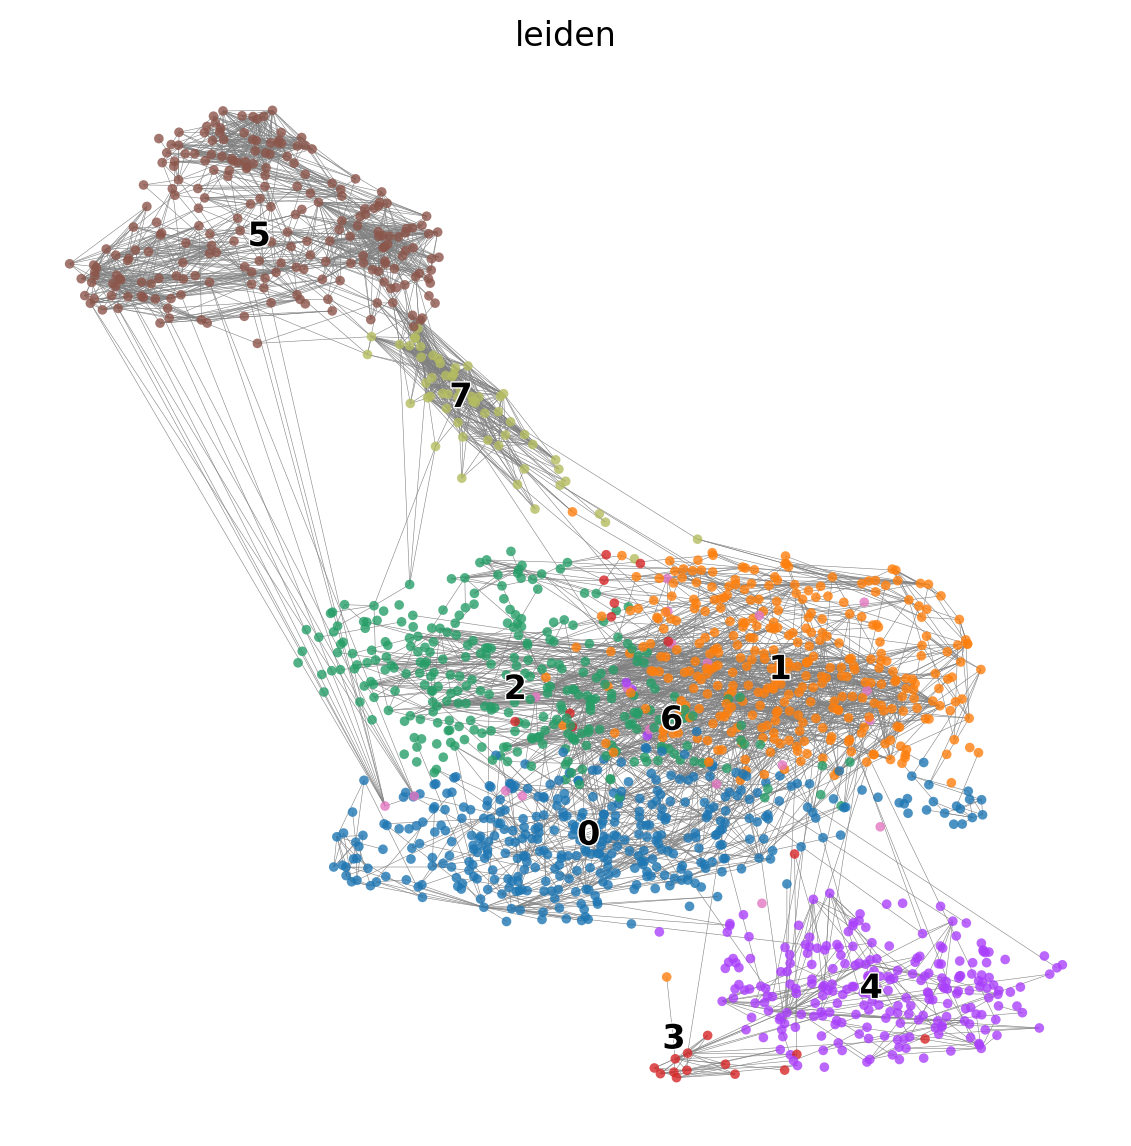

In [20]:
scv.pl.velocity_graph(adata_velocity, threshold=.1, color='leiden')

In [17]:
adata_velocity.uns['neighbors']['distances'] = adata_velocity.obsp['distances']
adata_velocity.uns['neighbors']['connectivities'] = adata_velocity.obsp['connectivities']

scv.tl.paga(adata_velocity, groups='leiden')
# df = scv.get_df(adata_velocity, 'paga/transitions_confidence', precision=2).T
# df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


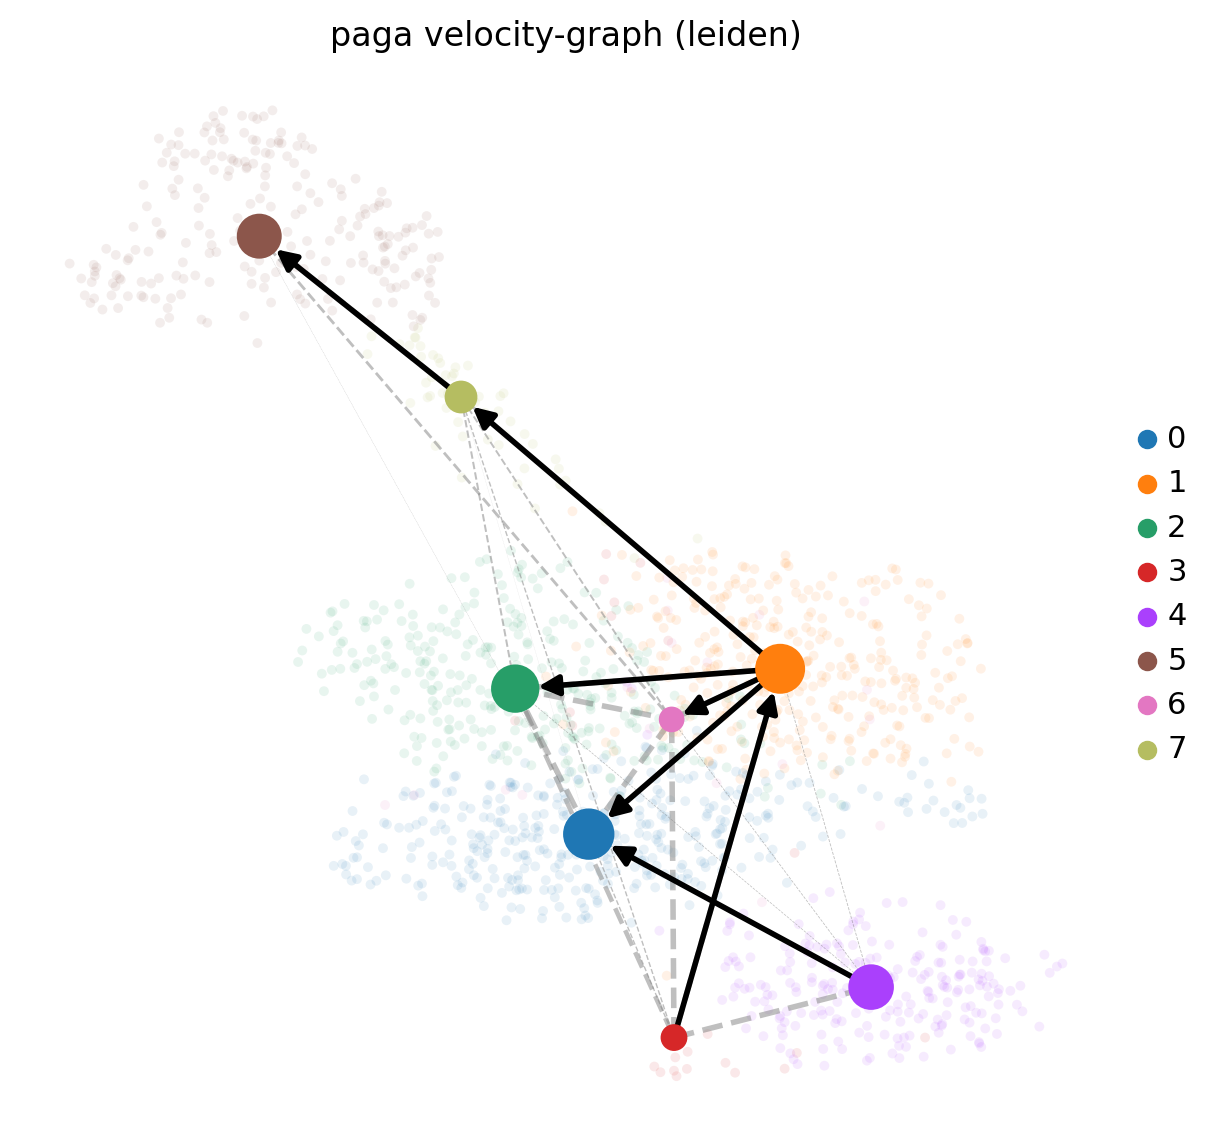

In [19]:
scv.pl.paga(adata_velocity, basis='umap', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)

In [21]:
adata_velocity.write("../data/processed/02_dataset.h5ad")

In [22]:
!jupyter nbconvert --to html 02_velocity.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 02_velocity.ipynb to html
[NbConvertApp] Writing 5525563 bytes to ../reports/02_velocity.html
